In [1]:
from numba import njit

import numpy as np
from numpy.linalg import norm

from cv2 import imread, imwrite, cvtColor, resize
from cv2 import COLOR_BGR2GRAY, COLOR_BGR2RGB

from tqdm import tqdm
from time import time

import random
import math

import matplotlib.pyplot as plt
%matplotlib inline

---

## Initialize

In [2]:
img1 = imread("1.png")
img2 = imread("2.png")
img3 = imread("3.png")
IMGS = np.array([img1.astype(np.float32), img2.astype(np.float32), img3.astype(np.float32)])

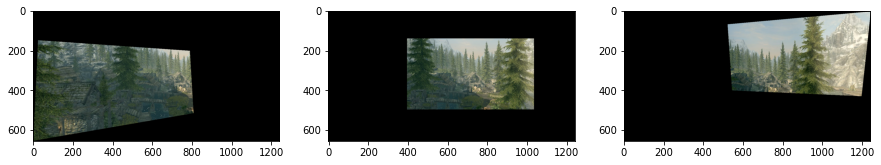

In [3]:
fig = plt.figure(figsize=(15, 12)) 
fig.add_subplot(1, 3, 1) 
plt.imshow(cvtColor(img1, COLOR_BGR2RGB)) 
fig.add_subplot(1, 3, 2) 
plt.imshow(cvtColor(img2, COLOR_BGR2RGB)) 
fig.add_subplot(1, 3, 3) 
plt.imshow(cvtColor(img3, COLOR_BGR2RGB)) 

In [4]:
h, w = img1.shape[:2]
print(img1.shape)

(655, 1241, 3)


In [5]:
img1 = (img1.flatten()).astype(np.float32)
img2 = (img2.flatten()).astype(np.float32)
img3 = (img3.flatten()).astype(np.float32)
IMGS_f = [img1, img2, img3]

---

In [6]:
# index = j + i*w - 1
y,x = 1, 6
index = x + y*w 
index, index // w, index % w 

(1247, 1, 6)

## Init

In [7]:
C = np.array([0,1,2], dtype=np.uint8)

In [8]:
# Neighbours ind
N = np.full((h*w, 4), -1, dtype = np.int32)

for i in range(h):
    for j in range(w):
        
        index = j + i*w

        # left
        if j > 0:
            left_index = j - 1 + i*w
            N[index, 0] = left_index
        # right
        if j < w - 1:
            right_index = j + 1 + i*w
            N[index, 1] = right_index
         # up
        if i > 0:
            up_index = j + (i-1)*w
            N[index, 2] = up_index
        # down
        if i < h - 1:
            down_index = j + (i+1)*w
            N[index, 3] = down_index

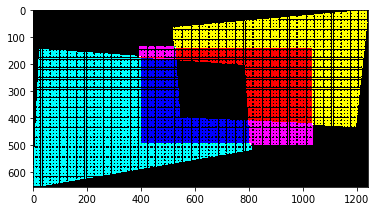

In [9]:
@njit
def init_q(IMGS, C, N):
    q = np.zeros((w*h, len(C)), dtype=np.float32)
    
    zero = np.zeros(3, dtype=np.uint8)
    for i in range(w*h):
        y,x = i // w, i % w
            
        if (IMGS[0][y,x,:] + IMGS[1][y,x,:] + IMGS[2][y,x,:] == np.zeros(3, dtype=np.uint8)).all():
            q[i, 0] = 0
            q[i, 0] = 0
            q[i, 0] = 0
        else:
            for c in C:
                if (IMGS[c][y,x,:] == zero).all():
                    q[i, c] = np.inf
                else:
                    q[i, c] = 0   
    return q
                    
q = init_q(IMGS, C, N)
plt.imshow(q.reshape((h,w,3)))

In [10]:
@njit
def init_g(IMGS, C, N):
    
    g = np.zeros((w*h, 4, len(C), len(C)), dtype=np.float32)
    
    for i in range(w*h):
        y,x = i // w, i % w
        
        for n_ind, n in enumerate(N[i]):
            y_, x_ = n // w, n % w
            
            for c in C:
                for c_ in C:
                    g[i, n_ind, c, c_] = norm(IMGS[c][y,x,:] - IMGS[c][y_,x_,:]) + norm(IMGS[c_][y,x,:] - IMGS[c_][y_,x_,:])    
    return g

g = init_g(IMGS, C, N)

In [11]:
#Init D, R

@njit
def initDR(D, R, C):
    
    for y in range(h-1, -1, -1):
        for x in range(w-1, -1, -1):
            for c in C:
                index = x + w*y
                
                # D
                if y == h-1:
                    D[y,x,c] = 0
                else:
                    index2 = N[index, 3]
                    
                    best_score = np.inf
                    for c_ in C:
                        foo = D[y+1, x, c_] + 0.5*q[index2, c_] + g[index, 3, c, c_]
                        if foo < best_score:
                            best_score = foo
                    D[y,x,c] = best_score
                    
                # R
                if x == w-1:
                    R[y,x,c] = 0
                else:
                    index2 = N[index, 1]
                    best_score = np.inf
                    for c_ in C:
                        foo = R[y, x+1, c_] + 0.5*q[index2, c_] + g[index, 1, c, c_]
                        if foo < best_score:
                            best_score = foo
                    R[y,x,c] = best_score

In [12]:
Phi = np.zeros((len(N), len(C)))

In [13]:
D = np.zeros((h, w, len(C)), dtype=np.float64)
R = np.zeros((h, w, len(C)), dtype=np.float64)
    
L = np.zeros((h, w, len(C)), dtype=np.float64)
U = np.zeros((h, w, len(C)), dtype=np.float64)

In [14]:
initDR(D, R, C)

---

# Main

In [15]:
@njit
def forwardpass(L, U, R, D, Phi, C):
    
    for y in range(0, h):
        for x in range(0, w):
            for c in C:
                index = x + w*y
                
                # U
                index2 = N[index, 2]
                if y == 0:
                    best_score = np.inf
                    for c_ in C:
                        foo = 0.5*q[index2, c_] + g[index, 2, c, c_] - Phi[index2, c_]
                        if foo < best_score:
                            best_score = foo
                    U[y,x,c] = best_score
                else:
                    best_score = np.inf
                    for c_ in C:
                        foo = U[y-1,x,c] + 0.5*q[index2, c_] + g[index, 2, c, c_] - Phi[index2, c_]
                        if foo < best_score:
                            best_score = foo
                    U[y,x,c] = best_score
                    
                # L
                index2 = N[index, 0]
                if x == 0:
                    best_score = np.inf
                    for c_ in C:
                        foo = 0.5*q[index2, c_] + g[index, 0, c, c_] - Phi[index2, c_]
                        if foo < best_score:
                            best_score = foo
                    L[y,x,c] = best_score
                else:
                    best_score = np.inf
                    for c_ in C:
                        foo = L[y,x-1,c] + 0.5*q[index2, c_] + g[index, 0, c, c_] - Phi[index2, c_]
                        if foo < best_score:
                            best_score = foo
                    L[y,x,c] = best_score
                    
                # Phi
                Phi[index, c] = ( L[y,x,c] + R[y,x,c] - U[y,x,c] - D[y,x,c] )*0.5

In [16]:
@njit
def backwardpass(L, U, R, D, Phi, C):
    
    for y in range(h-1, -1, -1):
        for x in range(w-1, -1, -1):
            for c in C:
                index = x + w*y
                
                # D
                if y == h-1:
                    D[y,x,c] = 0
                else:
                    index2 = N[index, 3]
                    
                    best_score = np.inf
                    for c_ in C:
                        foo = D[y+1, x, c_] + 0.5*q[index2, c_] + g[index, 3, c, c_] + Phi[index2, c]
                        if foo < best_score:
                            best_score = foo
                    D[y,x,c] = best_score
                    
                # R
                if x == w-1:
                    R[y,x,c] = 0
                else:
                    index2 = N[index, 1]
                    best_score = np.inf
                    for c_ in C:
                        foo = R[y, x+1, c_] + 0.5*q[index2, c_] + g[index, 1, c, c_] - Phi[index2, c]
                        if foo < best_score:
                            best_score = foo
                    R[y,x,c] = best_score
                    
                # Phi
                Phi[index, c] = ( L[y,x,c] + R[y,x,c] - U[y,x,c] - D[y,x,c] )*0.5

In [17]:
forwardpass(L, U, R, D, Phi, C)

In [18]:
backwardpass(L, U, R, D, Phi, C)

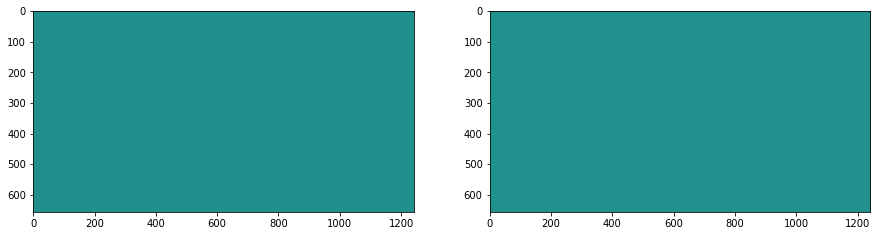

In [19]:
fig = plt.figure(figsize=(15, 15)) 
fig.add_subplot(1, 2, 1) 
plt.imshow(L[:,:,0]) 
fig.add_subplot(1, 2, 2) 
plt.imshow(U[:,:,0]) 

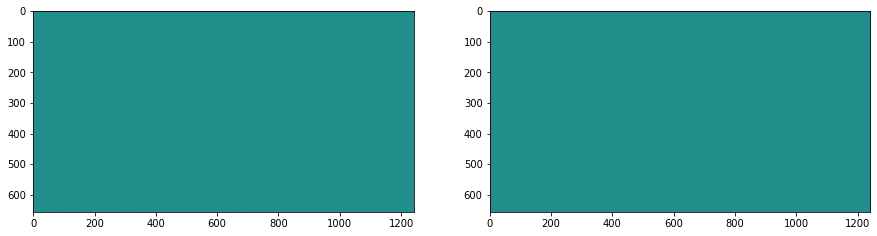

In [20]:
fig = plt.figure(figsize=(15, 15)) 
fig.add_subplot(1, 2, 1) 
plt.imshow(R[:,:,0]) 
fig.add_subplot(1, 2, 2) 
plt.imshow(D[:,:,0]) 

---

## Reconstruction

In [21]:
@njit
def reconstruct(L, R, Phi, C):
    Res = np.zeros((h,w), dtype=np.uint8)
    
    for y in range(0, h):
        for x in range(0, w):
            for c in C:
                index = x + w*y

                best_score = np.inf
                best_c = -1
                for c_ in C:
                    foo = L[y,x,c_] + R[y,x,c_] + 0.5*q[index, c_] - Phi[index, c_]
                    if foo < best_score:
                            best_score = foo
                            best_c = c_

                Res[y,x] = best_c
    return Res

In [22]:
Res = reconstruct(L, R, Phi, C)

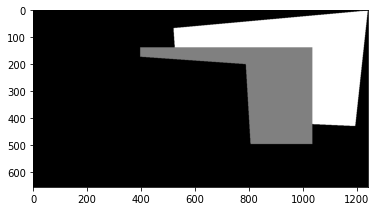

In [23]:
plt.imshow(Res, cmap='gray')

In [27]:
@njit
def render_result(Res, IMGS):
    
    res_img = np.zeros_like(IMGS[0])
    
    for y in range(0, h):
        for x in range(0,w):
            
            res_img[y,x,:] = IMGS[Res[y,x]][y,x,:]
            
    return res_img

Img = render_result(Res, IMGS).astype(np.uint8)

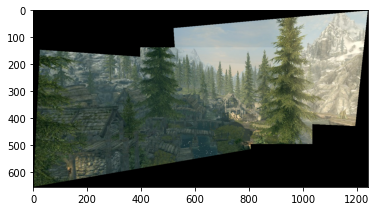

In [29]:
plt.imshow(cvtColor(Img, COLOR_BGR2RGB))
plt.imsave('res.png', cvtColor(Img, COLOR_BGR2RGB))

In [ ]:
i = 3
y,x = i // w, i % w + 1
index = x + (y+1)*w - 1
y1,x1 = index // w, index % w + 1

(f'i: {i} | y,x: {y,x} | index: {index} | y1,x1: {y1,x1}')